In [1]:
from graph_class import *
from nltk_class import *
from text_mining import *
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-white')
sns.set_style('white')
update_parameter()

# Loading dataset

Load the dataset and filter the tweets according to the dates, from '2021-08-26' to '2021-09-08'.

In [2]:
with open('noclean.json', 'r') as file:
    raw_tweet = pd.DataFrame(json.load(file))

dates_from, dates_to = '2021-08-26', '2021-09-08'
raw_tweet = raw_tweet.loc[(raw_tweet.created_at > dates_from) & (raw_tweet.created_at < dates_to)]

print(f'Whole Tweet: {len(raw_tweet)}, from {dates_from} to {dates_to}.')

Whole Tweet: 52684, from 2021-08-26 to 2021-09-08.


# Text preprocess

- We create a second dataframe having only the unique tweets
- we remove all the duplicates tweets.
- we remove the people tags (@).
- we remove all the unicode charachters.
- we remove all the italian stopwords.
- we remove tweets having less than 3 words

In [3]:
nlp = NltkTextProcessing()
tweet_unique = nlp.keep_unique(raw_tweet).reset_index(drop=True)
tweet_unique = nlp.process_df_text_column(tweet_unique, stem=False, min_len=3)
tweet_unique = nlp.process_df_hash_column(tweet_unique)

Tweets including retweets: 52684. Excluded: 13207


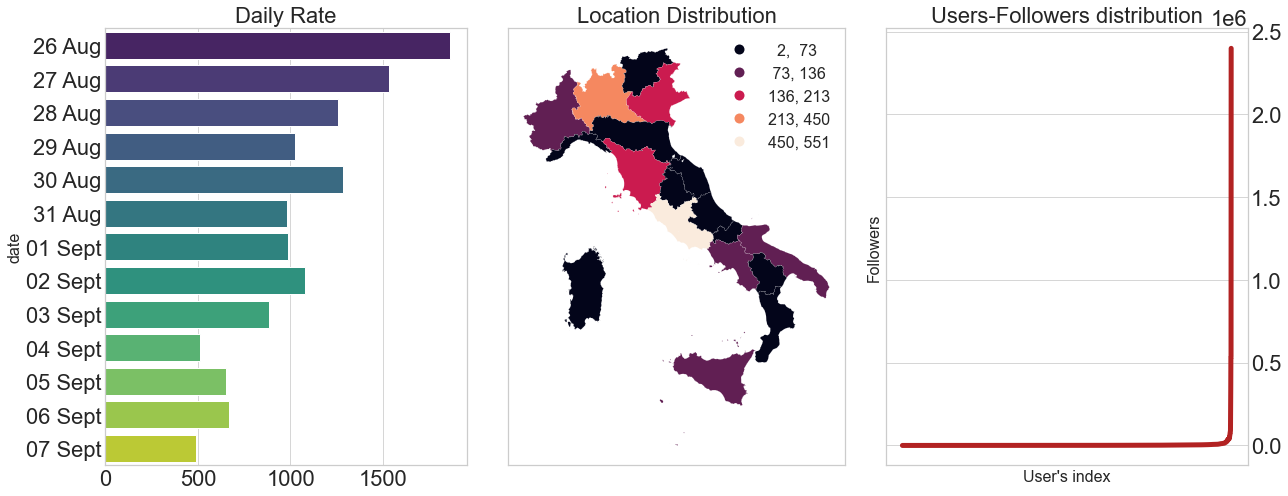

In [4]:
print(f"Tweets including retweets: {len(raw_tweet)}. Excluded: {len(tweet_unique)}")
nlp.plot_dates_location_followers(tweet_unique, save=True)

# TF-IDF for key words

- We extraxt the top 5000 features from the tweets
- We create a final corpus having 10151 documents and 3780 keywords (a matrix with NxM = 10151x3780).

In [5]:
mining = TextMining()

just_text = tweet_unique.tweet_text.apply(lambda x: ' '.join(x).upper()) #upper
vectorized_text = mining.vectorized_text(just_text.values.tolist()) #sparse matrix
features_name = mining.get_features_names() #names

n_keywords = 5000
filtered_words = mining.extract_topn_from_vector(features_name, mining.sort_coo(vectorized_text), n_keywords)
filtered_words_set = set(map(str.upper, set(filtered_words)))

tokenized_keywords = nlp.take_only_keywords_from_tweets(just_text, filtered_words_set, min_len=2)

Shape of the Sparse Matrix (13207, 26821), type: <class 'scipy.sparse.csr.csr_matrix'>
Keywords founded: 3780
Remained docs: 10151


In [6]:
mining = TextMining() #with filtered tweets

vectorized_text = mining.vectorized_text([' '.join(x) for x in tokenized_keywords])
freq_distrib_tweet = nlp.frequency_dist(tokenized_keywords, obj='mine') #calculate the frequency distribution

Shape of the Sparse Matrix (10151, 3396), type: <class 'scipy.sparse.csr.csr_matrix'>


# Semantic graph

- We create the graph inlcuding only keywords that appears at least 5 times.
- We look for the nodes having highest degree, betweeneess and closeness centrality.

In [7]:
min_occurencies = 5
main_word_graph =  NetworkPlot.graph_filtered_dist(tokenized_keywords, freq_distrib_tweet, min_occurencies, obj='mine') 

degree_centrality = networkx.algorithms.centrality.degree_centrality(main_word_graph)
betweeneness_centrality = networkx.algorithms.centrality.betweenness_centrality(main_word_graph)
centrality = [betweeneness_centrality, degree_centrality]

# closeness_centrality = networkx.algorithms.centrality.closeness_centrality(main_word_graph)
# centrality = [betweeneness_centrality, closeness_centrality, degree_centrality]

print(f"Number of nodes: {len(main_word_graph)}")

Number of nodes: 1374


- keep only the connected components
- find the most important nodes so to display the labels

In [8]:
min_node_degree = 4
top_n_centrality_word = 30

graph_min_degree = NetworkPlot.keep_minimun_degree(main_word_graph, min_node_degree)
top_words_min = NetworkPlot.get_set_top_centrality_words(centrality, top=top_n_centrality_word)
top_words_extended = NetworkPlot.extend_top_word(graph_min_degree, thresold=60, res=top_words_min)
NetworkPlot.keep_connected_components(graph_min_degree, min_degree = 10), f"number of words {len(top_words_extended)}"

(None, 'number of words 64')

In [9]:
for i in [3,5,10,20,50,100]: NetworkPlot.spectral_clustering(graph_min_degree,n_cluster=3, w='count', k=i)

Cluster distribution: [1354, 5, 10], Silhouette Score: -0.14157264922288376
Cluster distribution: [148, 1159, 62], Silhouette Score: 0.34666115763854677
Cluster distribution: [1111, 176, 82], Silhouette Score: 0.269307482446255
Cluster distribution: [1066, 101, 202], Silhouette Score: 0.22554548573415395
Cluster distribution: [473, 779, 117], Silhouette Score: 0.08383604978692462
Cluster distribution: [521, 679, 169], Silhouette Score: 0.018819836406567054


- Clustering the graph

In [10]:
n_cluster, k, gamma = 3, 100, 5
cluster, cluster_label = NetworkPlot.spectral_clustering(graph_min_degree,n_cluster=n_cluster, w='count', k=k)
to_plot = NetworkPlot(graph_min_degree, freq_distrib_tweet, labels = cluster_label)

Cluster distribution: [521, 679, 169], Silhouette Score: 0.018819836406567054


- Plot the graph

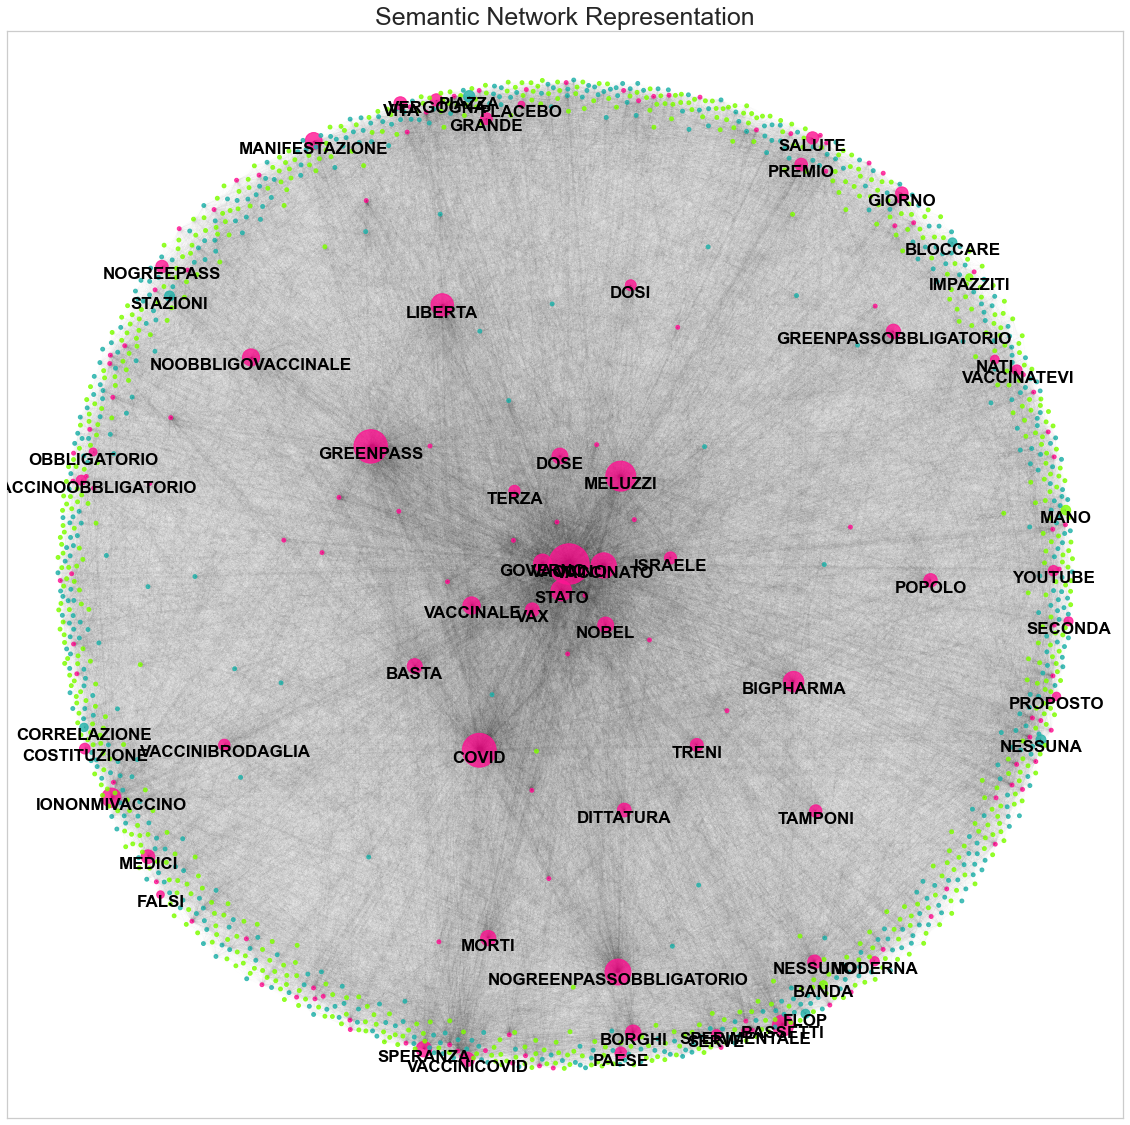

In [11]:
colors = ['lightseagreen', 'chartreuse', 'deeppink']
to_plot.plot_main_centrality(top_words_extended, 
                             mul_factor=1, 
                             save='graphs2', 
                             k=5.5, 
                             i=100, 
                             w=None, ka=False, 
                             c=colors, a=.012, s=10)

- Highest betwenness words

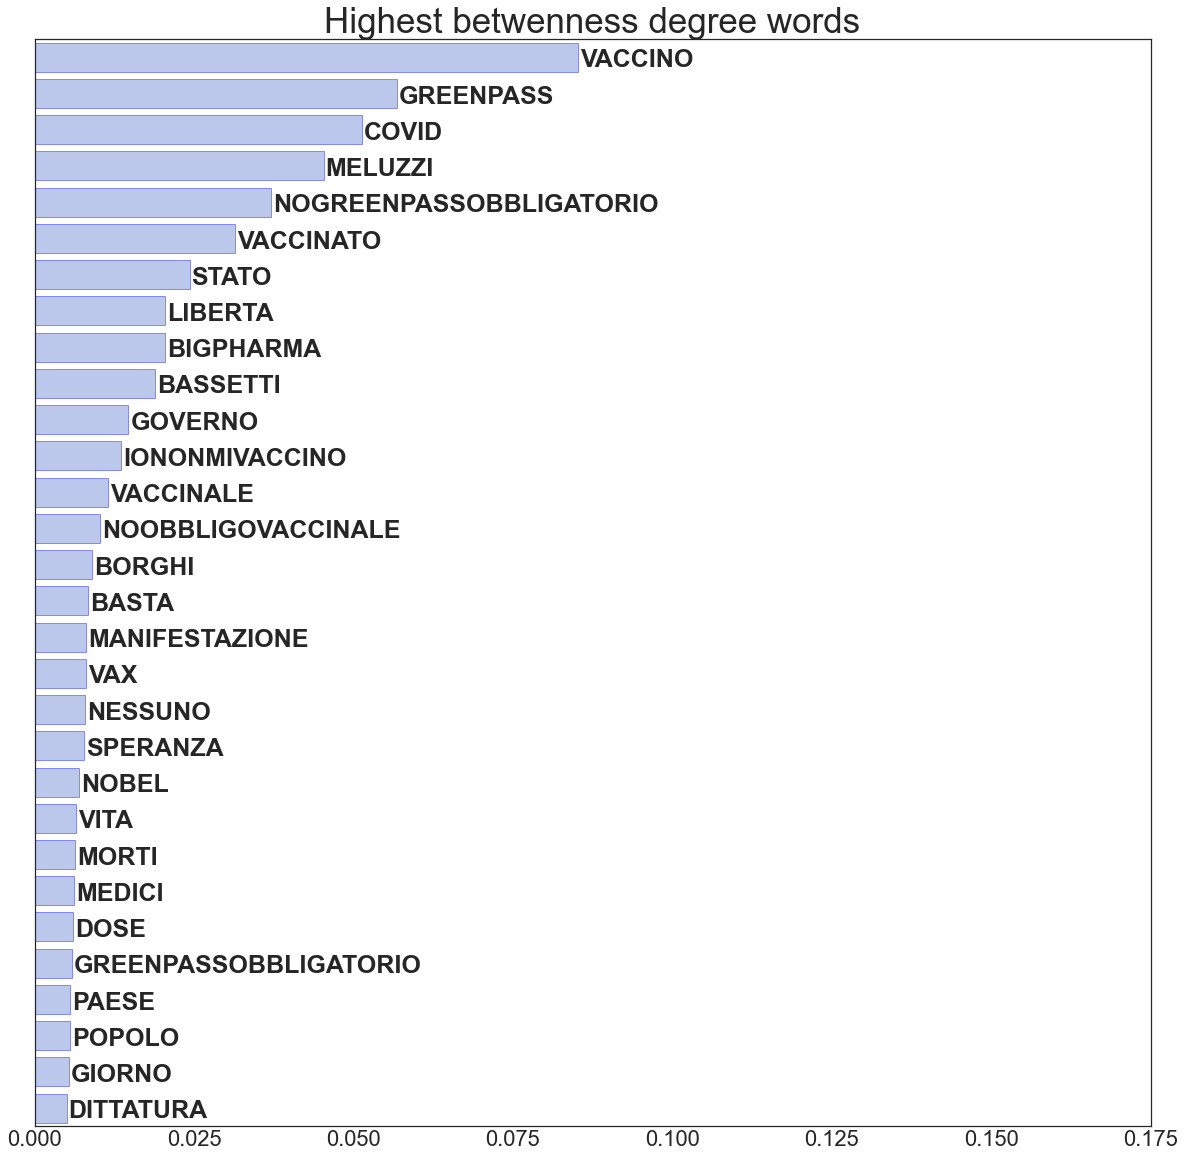

In [12]:
NetworkPlot.count_barplot(centrality[0], 
                          name='centrality', title='Highest betwenness degree words', 
                          to=30, ticks=np.arange (0, 0.20, 0.025), save=True)

# Latent Dirichlet Allocation

- Remove the too common words
- Compute the LDA with ngrams = (1,1)
- Plot the results

In [13]:
too_common = ['VACCINO','COVID', 'NOOBBLIGOVACCINALE','NOGREENPASSOBBLIGATORIO', 'IONONMIVACCINO']

for i in tokenized_keywords:
    for j in too_common: 
        if j.upper() in i: i.remove(j.upper())
vectorized_text = mining.vectorized_text([' '.join(x) for x in tokenized_keywords])

Shape of the Sparse Matrix (10151, 3391), type: <class 'scipy.sparse.csr.csr_matrix'>


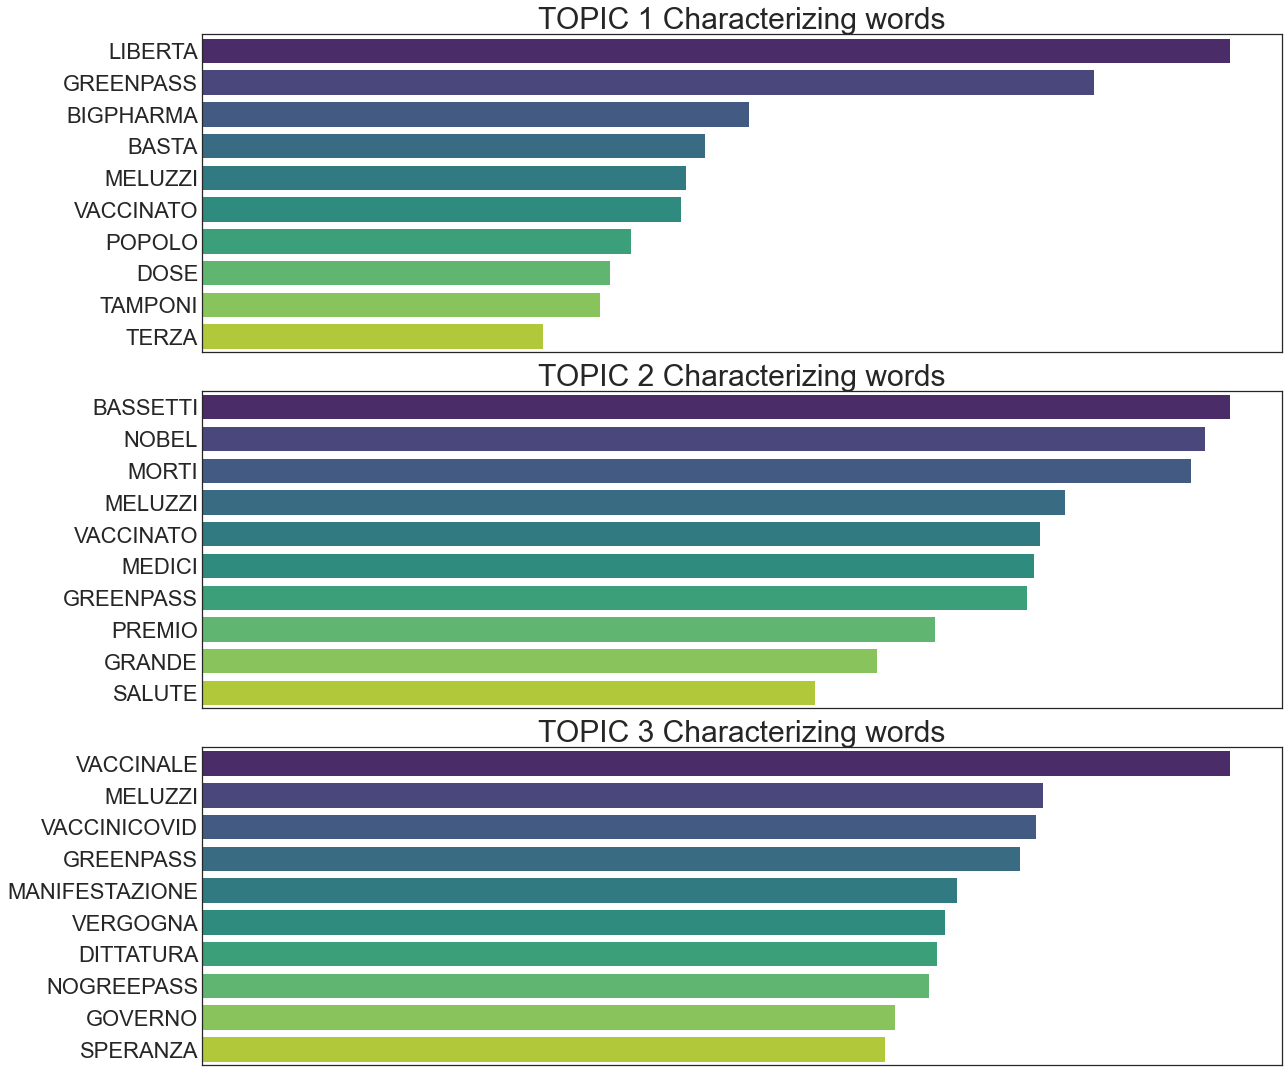

In [14]:
topics, top_word = 3,10
lda_model = mining.lda_topic_modeling(vectorized_text, topics) # count_vector?
mining.plot_lda_topic(lda_model, topics, n_top_words=top_word, save=True)

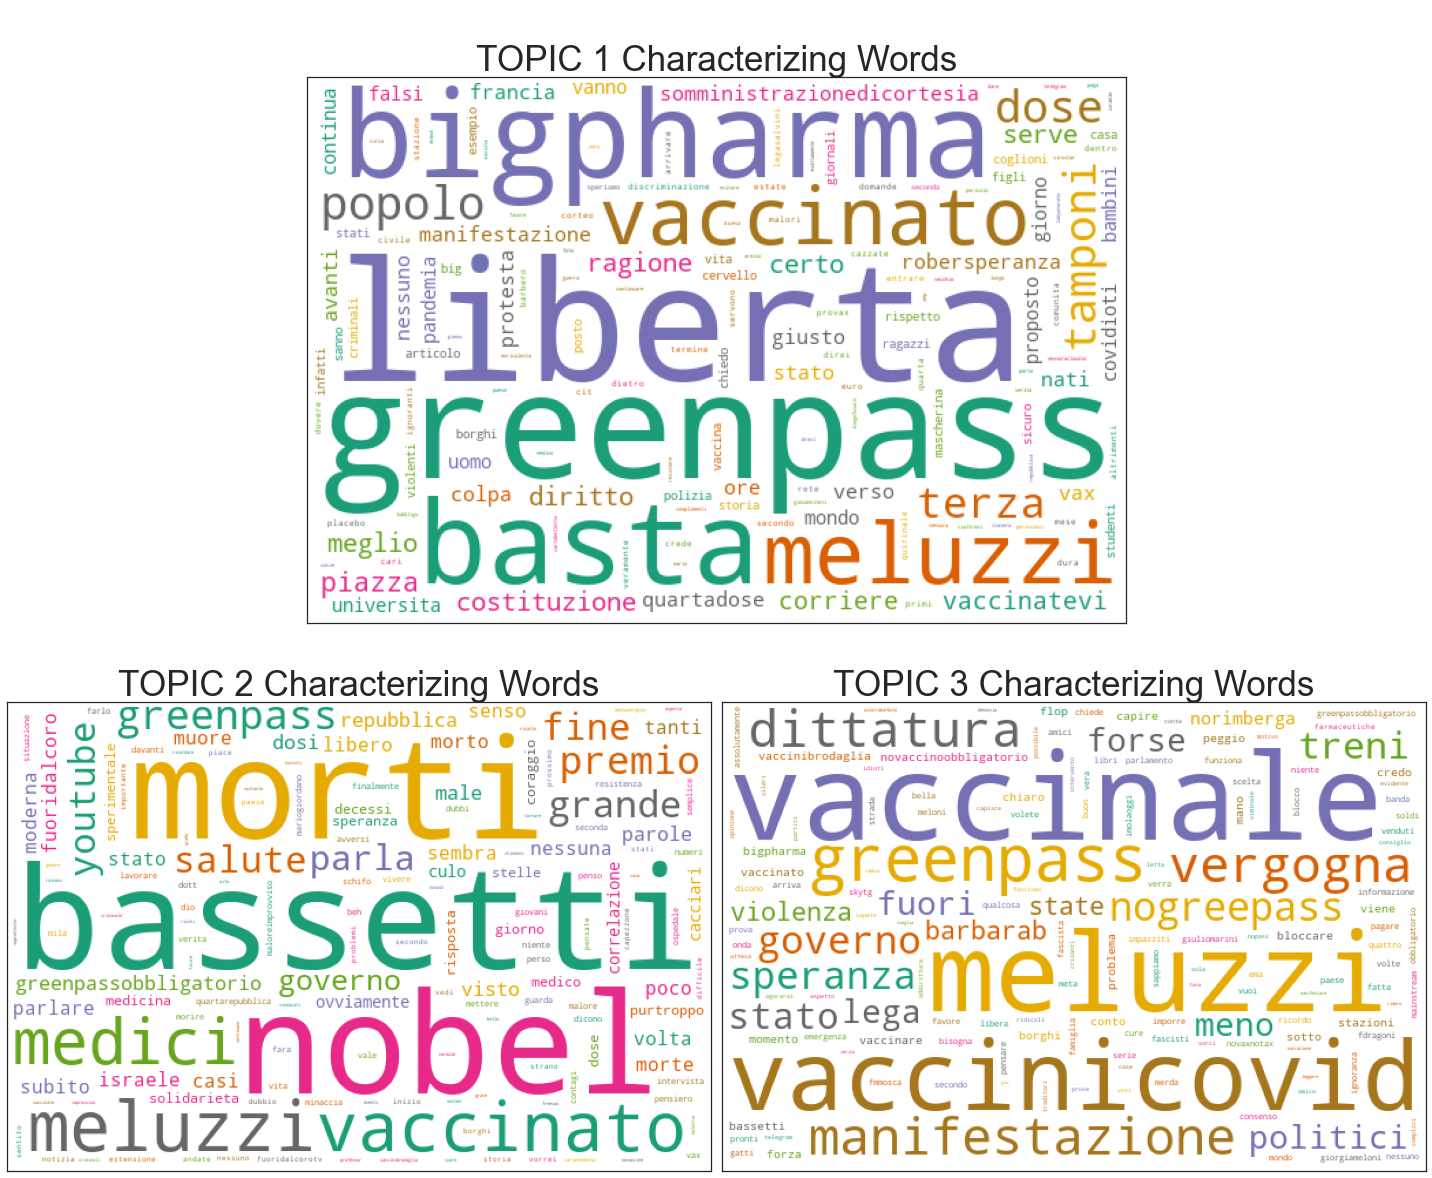

In [15]:
bag_of_words = mining.word_cloud_dict(lda_model)
mining.plot_wordcloud(bag_of_words, n_topics=3, save='lda-topics', palette='Dark2_r')

# External sources

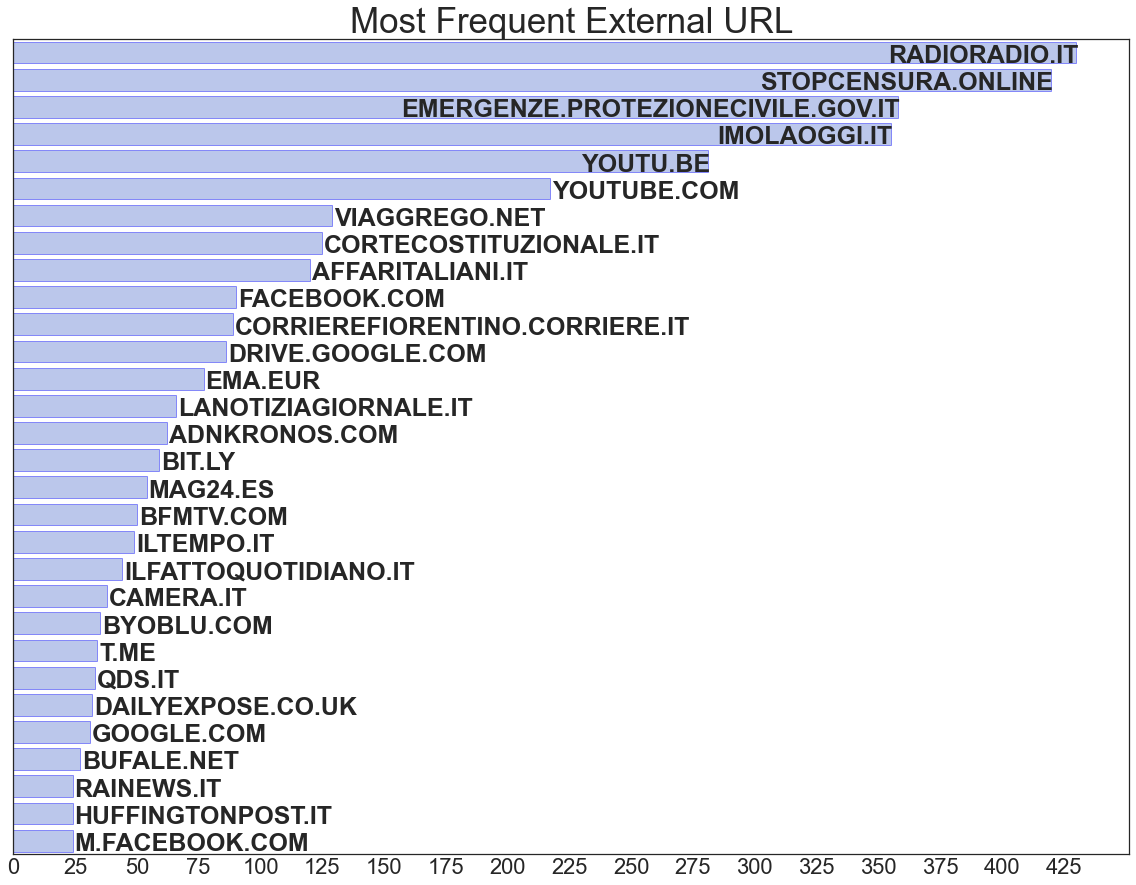

In [16]:
NetworkPlot.count_barplot(nlp.extract_external_url(raw_tweet),
                          name='countplot', title='Most Frequent External URL', 
                          to=30, ticks=[i for i in range(0, 450, 25)], r=True,
                          save=False, h=15, w=20, )

In [17]:
colors = ['lightseagreen', 'chartreuse', 'deeppink']@
for iel in range(100):
    to_plot.plot_main_centrality(top_words_extended, 
                                 mul_factor=1, 
                                 save=f'graphs{iel}', 
                                 k=5.8, 
                                 i=100, 
                                 w=None, ka=False, 
                                 c=colors, a=.012, s=iel)
    
for iel in range(100):
    to_plot.plot_main_centrality(top_words_extended, 
                                 mul_factor=1, 
                                 save=f'graphs__{iel}', 
                                 k=x[iel], 
                                 i=100, 
                                 w=None, ka=False, 
                                 c=colors, a=.012, s=iel)

SyntaxError: invalid syntax (<ipython-input-17-a2463ce8726e>, line 1)